In [64]:
import pandas as pd
import numpy as np
from glob import glob
from pathlib import Path

methods = {
    "bls_bspline": "bspline + BLS",
    "bls_wotan3D": "biweight + BLS",
    "bls_harmonics": "harmonics + BLS",
    "bens": "sinusoids + BLS (Ben's)",
    "nuance": "nuance",
}


targets = [int(Path(f).stem) for f in glob("../figures/searched/*")]

result_df = pd.DataFrame(columns=targets)

def right_candidate(t0, period, true_t0, true_period, verbose=False):
    t0_check = (
        np.abs((t0 - true_t0 + 0.5 * true_period) % true_period - 0.5 * true_period)
        % period
        < 0.01
    )
    period_check = np.abs(period - true_period) <= 0.01
    alias_check = np.abs(2 * period - true_period) <= 0.01
    alias_check |= np.abs(period / 2 - true_period) <= 0.01
    if period_check:
        return 1
    elif alias_check:
        return 1
    else:
        return 0

for target in targets:
    for method in methods:
        df = pd.read_csv(    
            f"../data/{target}/recovered/{method}/results.csv", index_col=0
        ) 
        df["found"] = df.apply(
            lambda row: right_candidate(
                0, row["period"], 0, row["true_period"]
            ),
            axis=1,
        )
        total_found= np.count_nonzero(df.found)/len(df)

        result_df.loc[method, target] = total_found * 100
    
    result_df.loc["fresh_snr", target] = df.fresh_snr.values[0]


gp_characteristics = {} 

import yaml

for target in targets:
    gp_characteristics[target] = yaml.safe_load(open(f"../data/{target}/gp.yaml"))

gp_characteristics = pd.DataFrame(gp_characteristics)

In [65]:
import matplotlib.pyplot as plt

snr = 6

# exclude nuance
good_ones = result_df.loc[:, (result_df.loc["fresh_snr"] < snr).values]
difference = (good_ones.iloc[-2] - good_ones.drop("nuance").max(axis=0))
gp_char = gp_characteristics[good_ones.columns]

In [66]:
gp_char

,302927533,245950135,14001734,317704790,416740234,349130112,234412953,207211020,172409573,178879452,...,96740590,93443364,264413099,40047077,220391763,245821931,176379866,122504261,142884342,386688792
log_Q,33.491853,22.594972,31.150805,30.875092,24.898747,25.450708,-1.697121,14.139701,35.124484,25.233542,...,25.173276,28.390286,23.358509,25.496407,3.451569,22.540457,26.544775,-44.934042,7.426425,26.732844
log_dQ,40.537897,9.791626,15.489930,-13.530684,27.696966,25.889322,3.834414,6.241314,13.247751,26.751834,...,28.950772,12.419290,24.473643,23.154781,6.849196,24.154564,26.460639,1.612322,-12.869013,20.584926
log_f,-27.945002,-7.584331,-0.647120,0.408903,-3.717460,-3.681905,-3.296277,-2.856035,-0.986474,-2.500940,...,-4.921195,-1.674088,-22.602335,0.105892,-5.163601,-3.277967,-17.601890,-46.242369,0.058620,-0.298884
log_jitter,-4.137949,-4.369520,-5.899311,-4.668333,-5.428310,-4.876370,-4.724862,-4.509418,-5.230619,-5.954605,...,-6.460912,-4.669600,-4.350248,-6.056012,-5.991096,-5.901095,-3.986356,-4.672640,-4.050815,-4.255431
log_long_sigma,-16.967848,-51.038100,-6.979212,-8.114555,-19.302912,-7.616487,-12.313254,-35.957259,-17.069972,-5.243146,...,-20.884088,-17.736699,-22.078608,-8.240578,-24.244592,-5.728079,-183.107536,-18.666169,-5.410193,-31.014060
log_period,-0.338192,-0.922306,-1.244765,-0.945914,-0.511019,-0.876261,-1.181776,-1.355327,-1.699032,-0.086677,...,-1.635576,-1.951354,-0.120262,-0.119435,-0.523195,-0.120642,-0.893989,-0.832485,-0.915244,-0.802591
log_short_scale,-4.756291,-3.342911,-3.748711,-4.136939,-3.337406,-133.748699,-0.710151,-4.759766,-2.357355,-26.505726,...,-27.592126,-3.210074,-2.167214,-3.515653,-4.402450,-27.237371,-2.161856,-39.185422,-4.787541,-3.424333
log_short_sigma,-5.135972,-6.803950,-6.209370,-6.920981,-7.186226,-58.607999,-6.701791,-6.762416,-7.940025,-14.805460,...,-17.067826,-5.962897,-6.571839,-6.942128,-7.422079,-14.956775,-5.675410,-14.618042,-5.962548,-5.689066
log_sigma,19.016254,9.869571,14.831709,14.624653,12.142299,12.088488,0.473018,6.087867,16.070761,12.279624,...,12.448364,13.148459,10.401666,11.174765,1.336995,10.366217,12.289295,-0.393878,2.826328,12.441858


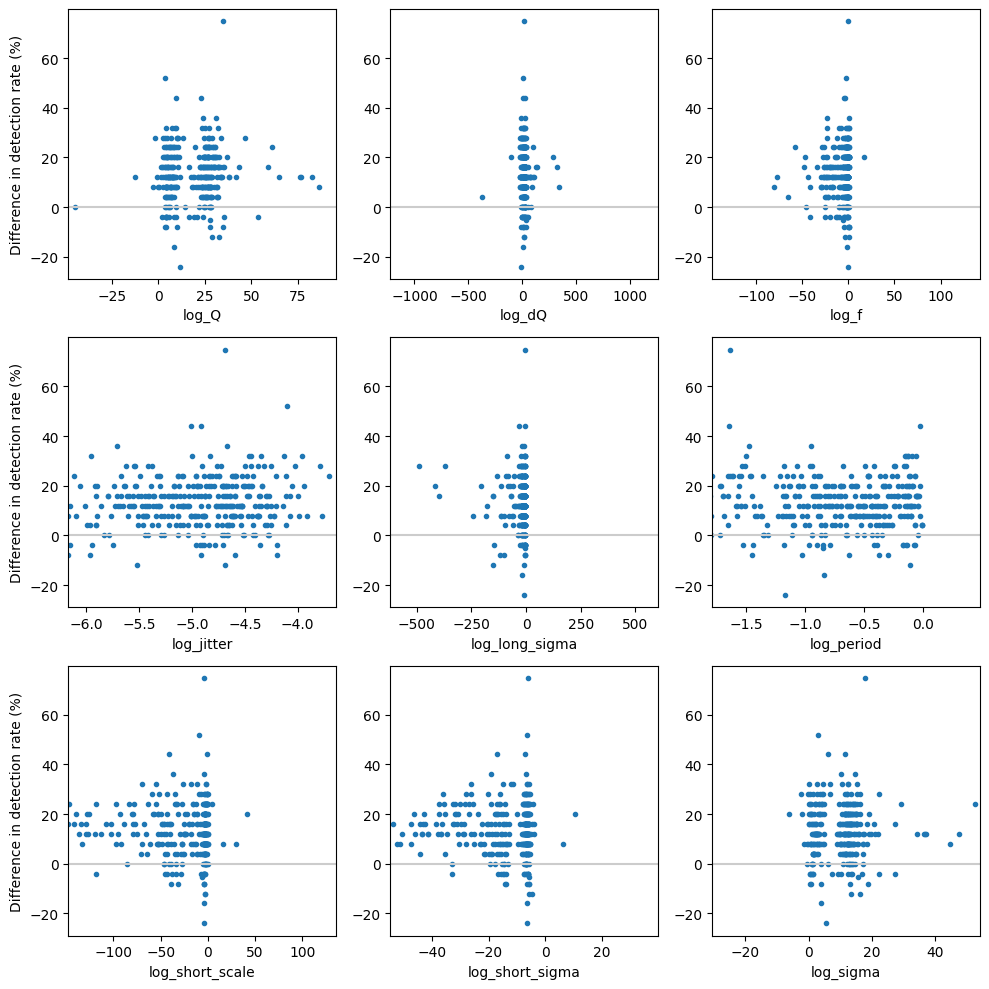

In [70]:
# grid of plots

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

n = int(np.ceil(np.sqrt(len(gp_char.index))))

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(n, n, figure=fig)

for i, key in enumerate(gp_char.index):
    if i<len(gp_char.index):
        ax = fig.add_subplot(gs[i])
        plt.plot(gp_char.loc[key].values, difference, ".")
        plt.axhline(0, c="0.8")
        mean = np.median(gp_char.loc[key].values)
        std = np.std(gp_char.loc[key].values)
        plt.xlim(*(mean + 2*std*np.array([-1, 1])))
        plt.xlabel(key)
        if i%n==0:
            plt.ylabel("Difference in detection rate (%)")

plt.tight_layout()
plt.savefig("../results/detection_rate_gp_params.pdf")